In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy import signal
from scipy.io import wavfile
import glob, os
import ipywidgets as widgets
from ipywidgets import interact
from bokeh.io import vplot, output_file, push_notebook  
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 7]
mpl.rcParams['figure.dpi'] = 100
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>") # Must be last to call

Loading BokehJS ...

In [3]:
files = glob.glob('*.wav')
soundFiles = {}
for file in files:
    samplingFreq, soundSignal = wavfile.read(file)
    soundFiles[file] = (samplingFreq, soundSignal)
    
soundFiles

{'DreiVentilatoren.wav': (44100,
  array([ -28, -249, -316, ...,    6,   -4,    3], dtype=int16)),
 'DreiVentilatorenZu.wav': (44100,
  array([ -173, -1757, -2124, ...,     5,    -5,     4], dtype=int16)),
 'EinVentilator.wav': (44100,
  array([  -6,  -74, -106, ...,    3,   -1,   -1], dtype=int16)),
 'EinVentilatorZu.wav': (44100,
  array([-1,  6, 20, ...,  5, -5,  3], dtype=int16)),
 'Meetingraum4.wav': (44100,
  array([ 1, 10, 14, ...,  6, -7,  5], dtype=int16)),
 'ZweiVentilatoren.wav': (44100,
  array([ 38, 420, 615, ...,   4,  -3,   3], dtype=int16)),
 'ZweiVentilatorenZu.wav': (44100,
  array([ -46, -507, -737, ...,    2,    0,   -2], dtype=int16))}

DreiVentilatoren.wav, Length: 38.86990929705215s, NumSamples: 1714163


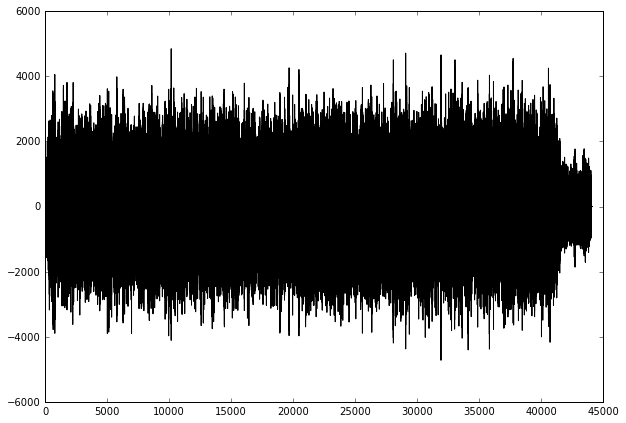

ZweiVentilatoren.wav, Length: 42.53852607709751s, NumSamples: 1875949


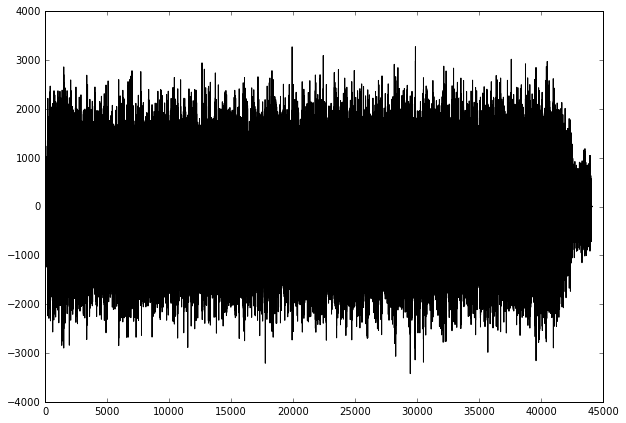

ZweiVentilatorenZu.wav, Length: 38.893083900226756s, NumSamples: 1715185


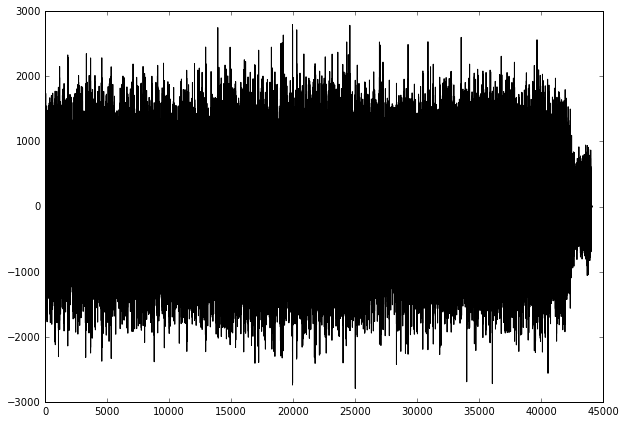

EinVentilatorZu.wav, Length: 38.96140589569161s, NumSamples: 1718198


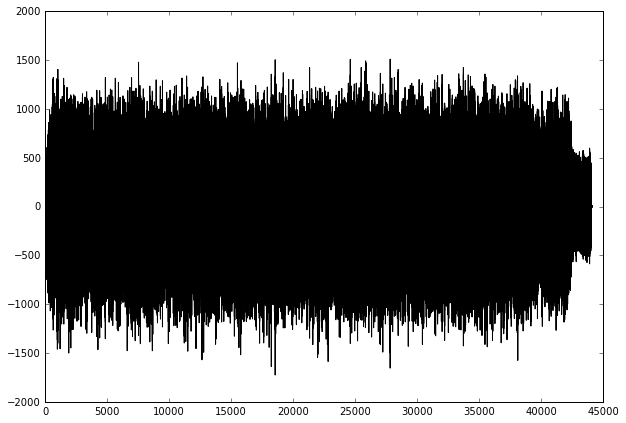

DreiVentilatorenZu.wav, Length: 41.7252380952381s, NumSamples: 1840083


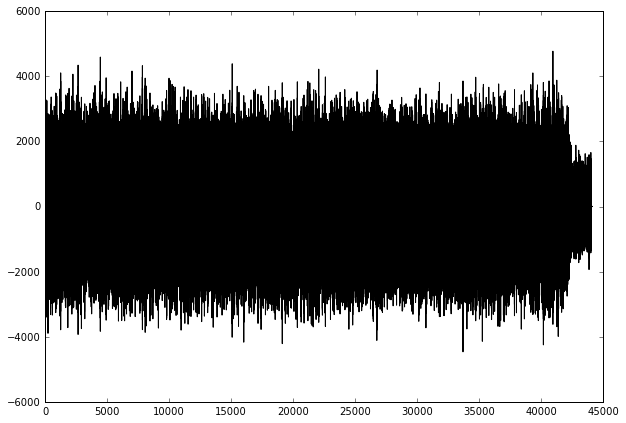

EinVentilator.wav, Length: 39.82140589569161s, NumSamples: 1756124


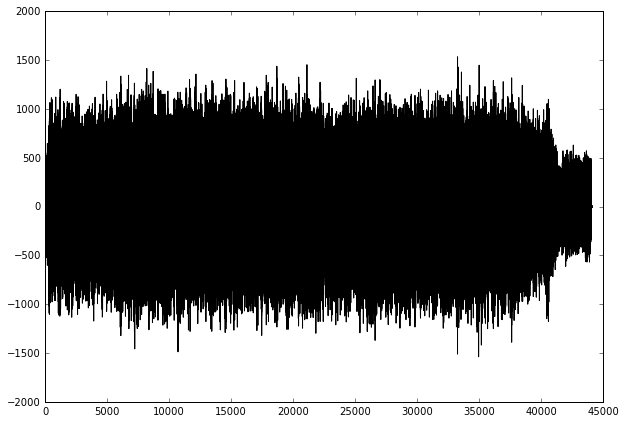

Meetingraum4.wav, Length: 30.90514739229025s, NumSamples: 1362917


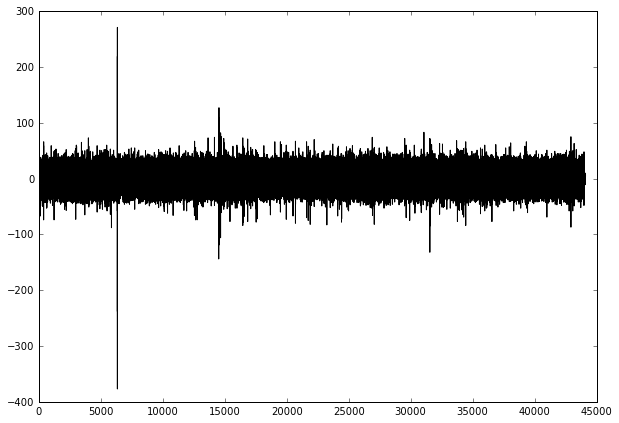

In [110]:
for key, value in soundFiles.items():
    timeLenght = len(value[1])/value[0]
    timearray = np.arange(0, len(value[1]), 1)/timeLenght
    print("{}, Length: {}s, NumSamples: {}".format(key, timeLenght, len(value[1])))
    plt.plot(timearray, value[1], color='k')
    plt.show()
    

In [5]:
# output_file("plot.html",  mode='cdn' )
TOOLS="resize,pan,wheel_zoom,box_zoom,reset,box_select,lasso_select"
plts = {}
scale = 100
for key, value in soundFiles.items():
# key, value = list(soundFiles.items())[0]
    timeLenght = len(value[1])/(value[0]*scale)
    timearray = np.arange(0, len(value[1]), 1*scale)/timeLenght
    title = "{}, Length: {}s, NumSamples: {}".format(key, timeLenght, len(value[1]/scale))
    plts[key] = figure(title=title, x_axis_label='time', y_axis_label='Amplitude',\
    plot_width=900, plot_height=300)
    plts[key].line(timearray, value[1][::scale])
plt = vplot(*list(plts.values()))
show(plt)

In [5]:
#Returns (powerspectrum, angles, frequenciesKhz) 
def powerAngeFreqFft(fs, values, slicelengthms = 0, sliceoffsetms = 0):
    if (slicelengthms == 0):
        slicelengthms = 1000*(len(values)/fs)
    samplePerMs = (fs/1000)
    pow2exp = np.ceil(np.log2(slicelengthms*samplePerMs))
    fftSamples = int(2**(pow2exp))
    offsetSample = int(sliceoffsetms*samplePerMs)
    while (fftSamples+offsetSample > len(values)):
        pow2exp = pow2exp - 1
        fftSamples = int(2**(pow2exp))
    pfft = np.fft.fft(values[offsetSample:offsetSample+fftSamples])
    nUniquePts = int(fftSamples/2)
    p = pfft[0:nUniquePts]
    p = abs(p) 
    p = p / float(fftSamples) # scale by the number of points so that
                 # the magnitude does not depend on the length 
                 # of the signal or on its sampling frequency  
    p = p**2  # square it to get the power  
    
    # multiply by two (see technical document for details)
    # odd nfft excludes Nyquist point
    if fftSamples % 2 > 0: # we've got odd number of points fft
        p[1:len(p)] = p[1:len(p)] * 2
    else:
        p[1:len(p) -1] = p[1:len(p) - 1] * 2 # we've got even number of points fft

    freqArray = np.arange(0, nUniquePts, 1.0) * (fs/(fftSamples*1000));
    return(10*np.log10(p), np.angle(pfft),freqArray)
    
 

In [19]:
# for key, value in soundFiles.items():
key, value = list(soundFiles.items())[0]
p,a,f = powerAngeFreqFft(value[0], value[1], 1000, 1000)
#    plt.xlabel('Frequency (kHz)')
#     plt.ylabel('Power (dB)')
#       plt.plot(f, p, color='k')    
bplt = figure(x_axis_label='frequency [khz]', y_axis_label='power [dB]',\
plot_width=1500, plot_height=300)
lne = bplt.line(f[f<5], p[f<5])

In [20]:
show(bplt)

In [8]:
@interact(recording=(0,len(soundFiles)-1,1), length=(0,30000,1000), offset=(0,30000,1000))
def update(recording = 0, length = 0, offset = 0):
     key, value = list(soundFiles.items())[recording]
     p,a,f = powerAngeFreqFft(value[0], value[1], length, offset)
     lne.data_source.data['x'] = f[f<5]
     lne.data_source.data['y'] = p[f<5] 
     bplt.title = "ds:{}, length:{}, offset:{}".format(key, length, offset)
     push_notebook()

In [21]:
@interact(recording={str(x):x for x in np.arange(0, len(soundFiles))})
def play_frequencies(recording=0):
    key, value = list(soundFiles.items())[recording]
    for start in np.arange(0, 1000*len(value[1])/value[0], 1000):
        update(recording=recording, length=1000, offset=start)
        time.sleep(0.5)

In [12]:
from IPython.display import display
import time
button = widgets.Button(description="Click Me!")
display(button)

def on_button_clicked(b):
    recording = 1
    key, value = list(soundFiles.items())[recording]
    for start in np.arange(0, 1000*len(value[1])/value[0], 1000):
        update(recording=recording, length=1000, offset=start)
        time.sleep(0.5)

button.on_click(on_button_clicked)